In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)
np.random.seed(100)

In [3]:
scores = pd.read_csv('2012-18_officialBoxScore.csv')
player_scores = pd.read_csv('2012-18_playerBoxScore.csv')
standings = pd.read_csv('2012-18_standings.csv')
team_scores = pd.read_csv('2012-18_teamBoxScore.csv')
college = pd.read_csv('college.csv')

### Predicting whether a team will make the playoffs next season based on past 3 seasons.
#### 1. Data Cleaning

In [4]:
scores_cpy = scores.copy()
# remove all the opponent stats because they are repeated later
scores_cpy = scores_cpy.iloc[:,:61]

#remove unnecessary stats
scores_cpy.drop(columns=['gmTime', 'seasTyp', 'offLNm', 'offFNm', 'teamConf', 'teamDiv', 'teamLoc', 'teamMin', 'teamDayOff'], inplace=True)

# remove duplicate rows
scores_cpy.drop_duplicates(inplace=True)

# adjust the date to be seasons
scores_cpy['gmDate'] = pd.to_datetime(scores_cpy['gmDate'])
season_range = {'201213': (scores_cpy['gmDate'] >= '2012-10-30') & (scores_cpy['gmDate'] <='2013-04-17'), \
          '201314': (scores_cpy['gmDate'] >= '2013-10-29') & (scores_cpy['gmDate'] <='2014-04-16'), \
          '201415': (scores_cpy['gmDate'] >= '2014-10-28') & (scores_cpy['gmDate'] <='2015-04-15'), \
          '201516': (scores_cpy['gmDate'] >= '2015-10-27') & (scores_cpy['gmDate'] <='2016-04-13'), \
          '201617': (scores_cpy['gmDate'] >= '2016-10-25') & (scores_cpy['gmDate'] <='2017-04-12'), \
          '201718': (scores_cpy['gmDate'] >= '2017-10-17') & (scores_cpy['gmDate'] <='2018-04-11')}

seasons_data = []
for key in season_range.keys():
    curr = scores_cpy.loc[season_range[key]]
    curr['season'] = [key]*len(curr)
    curr.drop(columns=['gmDate'], inplace=True)
    seasons_data.append(curr)
all_seasons = pd.concat(seasons_data)

# one-hot-encoding for Win/Loss to be 1/0. Note that we drop one of these columns because they are linearly dependent
win = pd.get_dummies(all_seasons['teamRslt'], prefix='Result', drop_first = True)['Result_Win']
all_seasons['Win'] = win
all_seasons.drop(columns='teamRslt', inplace=True)

# # for each season, find the team's average stats 
stats_by_season = all_seasons.groupby(['season', 'teamAbbr']).mean()

stats_by_season

teamPTS    teamAST     teamTO   teamSTL   teamBLK  \
season teamAbbr                                                         
201213 ATL        97.951220  24.475610  14.865854  8.097561  4.500000   
       BKN        96.878049  20.341463  14.707317  7.304878  4.768293   
       BOS        96.518519  22.753086  14.580247  8.234568  4.506173   
       CHA        93.426829  19.353659  14.073171  7.195122  5.841463   
       CHI        93.182927  23.000000  14.280488  7.170732  5.085366   
...                     ...        ...        ...       ...       ...   
201718 SA        102.731707  22.792683  13.182927  7.670732  5.597561   
       SAC        98.829268  21.573171  13.743902  7.890244  4.121951   
       TOR       111.634146  24.329268  13.390244  7.646341  6.109756   
       UTA       104.146341  22.426829  14.743902  8.646341  5.134146   
       WAS       106.609756  25.182927  14.634146  7.902439  4.243902   

                    teamPF    teamFGA    teamFGM   teamFG%    team2PA  \
season teamAbbr                                                         
201213 ATL       17.963415  81.024390  37.609756  0.465584  57.841463   
       BKN       18.292683  79.804878  35.878049  0.449987  58.341463   
       BOS       21.197531  79.740741  37.049383  0.466365  62.580247   
       CHA       19.048780  81.085366  34.426829  0.425313  64.024390   
       CHI       19.719512  81.682927  35.682927  0.438539  66.256098   
...                    ...        ...        ...       ...        ...   
201718 SA        17.170732  85.341463  39.048780  0.457772  61.231707   
       SAC       19.987805  86.109756  38.768293  0.450896  62.121951   
       TOR       21.743902  87.414634  41.256098  0.472657  54.414634   
       UTA       19.609756  82.878049  38.280488  0.462518  53.304878   
       WAS       21.292683  85.536585  39.939024  0.467939  59.036585   

                   team2PM   team2P%    team3PA    team3PM   team3P%  \
season teamAbbr                                                        
201213 ATL       29.000000  0.504110  23.182927   8.609756  0.373288   
       BKN       28.219512  0.484071  21.463415   7.658537  0.356373   
       BOS       30.901235  0.496393  17.160494   6.148148  0.360021   
       CHA       28.707317  0.448746  17.060976   5.719512  0.333800   
       CHI       30.243902  0.458105  15.426829   5.439024  0.350826   
...                    ...       ...        ...        ...       ...   
201718 SA        30.560976  0.499205  24.109756   8.487805  0.352216   
       SAC       29.768293  0.480474  23.987805   9.000000  0.376822   
       TOR       29.451220  0.544145  33.000000  11.804878  0.357084   
       UTA       27.463415  0.518249  29.573171  10.817073  0.366495   
       WAS       30.012195  0.509760  26.500000   9.926829  0.372939   

                   teamFTA    teamFTM   teamFT%    teamORB    teamDRB  \
season teamAbbr                                                         
201213 ATL       19.743902  14.121951  0.708479   9.243902  31.621951   
       BKN       23.878049  17.463415  0.732144  12.768293  30.000000   
       BOS       20.962963  16.271605  0.776423   8.074074  31.271605   
       CHA       25.121951  18.853659  0.753800  11.182927  29.134146   
       CHI       21.195122  16.378049  0.774287  12.512195  30.658537   
...                    ...        ...       ...        ...        ...   
201718 SA        20.914634  16.146341  0.778084  10.329268  33.853659   
       SAC       16.719512  12.292683  0.740568   9.475610  31.414634   
       TOR       21.829268  17.341463  0.787968   9.780488  34.207317   
       UTA       21.536585  16.768293  0.783278   9.012195  34.231707   
       WAS       21.780488  16.804878  0.774693  10.024390  33.048780   

                   teamTRB   teamPTS1   teamPTS2   teamPTS3   teamPTS4  \
season teamAbbr                                                          
201213 ATL       40.865854  23.841463  24.768293  24.975610  23.402439   
       BKN 

In [5]:
# clean the standings table to work out play-off booleans
# first make dates in date format and then separate by seasons
standings['stDate'] = pd.to_datetime(standings['stDate'])
season_range = {'201213': (standings['stDate'] >= '2012-10-30') & (standings['stDate'] <='2013-04-17'), \
          '201314': (standings['stDate'] >= '2013-10-29') & (standings['stDate'] <='2014-04-16'), \
          '201415': (standings['stDate'] >= '2014-10-28') & (standings['stDate'] <='2015-04-15'), \
          '201516': (standings['stDate'] >= '2015-10-27') & (standings['stDate'] <='2016-04-13'), \
          '201617': (standings['stDate'] >= '2016-10-25') & (standings['stDate'] <='2017-04-12'), \
          '201718': (standings['stDate'] >= '2017-10-17') & (standings['stDate'] <='2018-04-11')}

standings_data = []
for key in season_range.keys():
    curr = standings.loc[season_range[key]]
    curr['season'] = [key]*len(curr)
    standings_data.append(curr)
all_standings = pd.concat(standings_data)

# find standings at end of the season
end_dates = ['2013-04-17', '2014-04-16', '2015-04-15', '2016-04-13', '2017-04-12', '2018-04-11']
all_standings = all_standings[all_standings['stDate'].isin(end_dates)]
all_standings.drop(columns='stDate', inplace=True)
rankings = all_standings[['teamAbbr', 'rank', 'season']]
rankings = rankings.groupby(['season', 'teamAbbr']).mean()
rankings

rank
season teamAbbr      
201213 ATL          6
       BKN          4
       BOS          7
       CHA         14
       CHI          5
...               ...
201718 SA           7
       SAC         12
       TOR          1
       UTA          4
       WAS          8

[180 rows x 1 columns]

In [6]:
# join the rankings and stats_by_season so we know the standings of teams at end of each season
all_data = rankings.join(stats_by_season, how='inner')

# add a boolean value of whether they make playoffs
all_data['playoffs'] = (all_data['rank'] <= 8).astype(int)
all_data.drop(columns='rank', inplace=True)
all_data

teamPTS    teamAST     teamTO   teamSTL   teamBLK  \
season teamAbbr                                                         
201213 ATL        97.951220  24.475610  14.865854  8.097561  4.500000   
       BKN        96.878049  20.341463  14.707317  7.304878  4.768293   
       BOS        96.518519  22.753086  14.580247  8.234568  4.506173   
       CHA        93.426829  19.353659  14.073171  7.195122  5.841463   
       CHI        93.182927  23.000000  14.280488  7.170732  5.085366   
...                     ...        ...        ...       ...       ...   
201718 SA        102.731707  22.792683  13.182927  7.670732  5.597561   
       SAC        98.829268  21.573171  13.743902  7.890244  4.121951   
       TOR       111.634146  24.329268  13.390244  7.646341  6.109756   
       UTA       104.146341  22.426829  14.743902  8.646341  5.134146   
       WAS       106.609756  25.182927  14.634146  7.902439  4.243902   

                    teamPF    teamFGA    teamFGM   teamFG%    team2PA  \
season teamAbbr                                                         
201213 ATL       17.963415  81.024390  37.609756  0.465584  57.841463   
       BKN       18.292683  79.804878  35.878049  0.449987  58.341463   
       BOS       21.197531  79.740741  37.049383  0.466365  62.580247   
       CHA       19.048780  81.085366  34.426829  0.425313  64.024390   
       CHI       19.719512  81.682927  35.682927  0.438539  66.256098   
...                    ...        ...        ...       ...        ...   
201718 SA        17.170732  85.341463  39.048780  0.457772  61.231707   
       SAC       19.987805  86.109756  38.768293  0.450896  62.121951   
       TOR       21.743902  87.414634  41.256098  0.472657  54.414634   
       UTA       19.609756  82.878049  38.280488  0.462518  53.304878   
       WAS       21.292683  85.536585  39.939024  0.467939  59.036585   

                   team2PM   team2P%    team3PA    team3PM   team3P%  \
season teamAbbr                                                        
201213 ATL       29.000000  0.504110  23.182927   8.609756  0.373288   
       BKN       28.219512  0.484071  21.463415   7.658537  0.356373   
       BOS       30.901235  0.496393  17.160494   6.148148  0.360021   
       CHA       28.707317  0.448746  17.060976   5.719512  0.333800   
       CHI       30.243902  0.458105  15.426829   5.439024  0.350826   
...                    ...       ...        ...        ...       ...   
201718 SA        30.560976  0.499205  24.109756   8.487805  0.352216   
       SAC       29.768293  0.480474  23.987805   9.000000  0.376822   
       TOR       29.451220  0.544145  33.000000  11.804878  0.357084   
       UTA       27.463415  0.518249  29.573171  10.817073  0.366495   
       WAS       30.012195  0.509760  26.500000   9.926829  0.372939   

                   teamFTA    teamFTM   teamFT%    teamORB    teamDRB  \
season teamAbbr                                                         
201213 ATL       19.743902  14.121951  0.708479   9.243902  31.621951   
       BKN       23.878049  17.463415  0.732144  12.768293  30.000000   
       BOS       20.962963  16.271605  0.776423   8.074074  31.271605   
       CHA       25.121951  18.853659  0.753800  11.182927  29.134146   
       CHI       21.195122  16.378049  0.774287  12.512195  30.658537   
...                    ...        ...       ...        ...        ...   
201718 SA        20.914634  16.146341  0.778084  10.329268  33.853659   
       SAC       16.719512  12.292683  0.740568   9.475610  31.414634   
       TOR       21.829268  17.341463  0.787968   9.780488  34.207317   
       UTA       21.536585  16.768293  0.783278   9.012195  34.231707   
       WAS       21.780488  16.804878  0.774693  10.024390  33.048780   

                   teamTRB   teamPTS1   teamPTS2   teamPTS3   teamPTS4  \
season teamAbbr                                                          
201213 ATL       40.865854  23.841463  24.768293  24.975610  23.402439   
       BKN 

In [7]:
# create a new table which has the mean of past 3 seasons and whether the team makes playoffs next season. 
# Note the input into 'rolling' is the # seasons for our moving average window
mov_avg_data = all_data.groupby('teamAbbr').rolling(3).mean()

# remove the NaN rows which are because first 2 seasons for MA don't exist 
mov_avg_data = mov_avg_data.dropna()
mov_avg_data.index = mov_avg_data.index.droplevel(2)
mov_avg_data

teamPTS    teamAST     teamTO   teamSTL   teamBLK  \
teamAbbr season                                                         
ATL      201415  100.500000  25.036585  14.788618  8.487805  4.365854   
         201516  102.130081  25.414634  14.821138  8.833333  4.849593   
         201617  102.849593  24.995935  14.995935  8.792683  5.150407   
         201718  103.117886  24.329268  15.434959  8.361789  5.024390   
BKN      201415   97.808943  20.723577  14.353659  7.642276  4.235772   
...                     ...        ...        ...       ...       ...   
UTA      201718  100.845528  20.508130  14.443089  7.678862  5.085366   
WAS      201415   97.471545  22.979675  14.939024  7.589431  4.597561   
         201516  101.089431  23.914634  14.731707  8.040650  4.378049   
         201617  103.930894  24.105691  14.548780  8.150407  4.243902   
         201718  106.621951  24.495935  14.414634  8.341463  4.121951   

                    teamPF    teamFGA    teamFGM   teamFG%    team2PA  \
teamAbbr season                                                         
ATL      201415  18.321138  81.426829  37.666667  0.463769  56.349593   
         201516  18.715447  82.560976  38.008130  0.461434  55.752033   
         201617  18.365854  83.500000  38.260163  0.459267  56.605691   
         201718  18.971545  84.784553  38.296748  0.452790  56.296748   
BKN      201415  19.739837  80.239837  36.349593  0.453937  58.634146   
...                    ...        ...        ...       ...        ...   
UTA      201718  19.544715  80.890244  37.109756  0.459954  54.434959   
WAS      201415  20.581301  82.939024  37.504065  0.453757  64.317073   
         201516  20.691057  84.321138  38.837398  0.462157  63.719512   
         201617  20.975610  85.191057  39.695122  0.467349  63.260163   
         201718  21.134146  86.101626  40.247967  0.468488  60.955285   

                   team2PM   team2P%    team3PA    team3PM   team3P%  \
teamAbbr season                                                        
ATL      201415  28.349593  0.505089  25.077236   9.317073  0.371079   
         201516  28.247967  0.508332  26.808943   9.760163  0.363832   
         201617  28.658537  0.508111  26.894309   9.601626  0.357689   
         201718  28.292683  0.505010  28.487805  10.004065  0.352122   
BKN      201415  28.715447  0.491897  21.605691   7.634146  0.348384   
...                    ...       ...        ...        ...       ...   
UTA      201718  27.467480  0.507830  26.455285   9.642276  0.364798   
WAS      201415  30.638211  0.478028  18.621951   6.865854  0.368063   
         201516  31.304878  0.493264  20.601626   7.532520  0.365316   
         201617  31.719512  0.503422  21.930894   7.975610  0.364363   
         201718  30.983740  0.509740  25.146341   9.264228  0.368262   

                   teamFTA    teamFTM   teamFT%    teamORB    teamDRB  \
teamAbbr season                                                         
ATL      201415  20.878049  15.849593  0.755977   8.886179  31.585366   
         201516  20.955285  16.353659  0.779136   8.560976  32.313008   
         201617  22.000000  16.727642  0.760153   9.097561  33.252033   
         201718  21.670732  16.520325  0.763680   9.203252  33.581301   
BKN      201415  23.483740  17.475610  0.744882  10.626016  30.463415   
...                    ...        ...       ...        ...        ...   
UTA      201718  22.463415  16.983740  0.758240   9.719512  33.532520   
WAS      201415  21.215447  15.597561  0.736546  10.715447  32.626016   
         201516  21.634146  15.882114  0.734313  10.130081  32.772358   
         201617  22.028455  16.565041  0.753103   9.947154  33.162602   
         201718  22.142276  16.861789  0.765148   9.780488  32.792683   

                   teamTRB   teamPTS1   teamPTS2   teamPTS3   teamPTS4  \
teamAbbr season                                                          
ATL      201415  40.471545  24.491870  25.235772  25.333333  24.686992   
         20

In [8]:
# add a column of whether the team made playoffs in the next season
# 2018-19 season playoffs data which is manually inputted from wikipedia
season_1819 = pd.DataFrame()
season_1819['teamAbbr'] = rankings.index.get_level_values('teamAbbr').unique().tolist()
season_1819['playoffs'] = [0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0]
season_1819['season'] = ['201819'] * len(season_1819)
seasons_playoff = all_data['playoffs'].reset_index()
seasons_playoff.append(season_1819)

# remove the 2012-13 season data
seasons_playoff = seasons_playoff[seasons_playoff['season'] != '201213']
seasons_playoff.columns = ['next_season', 'teamAbbr', 'next_playoffs']

In [9]:
# using a dictionary of dates, have a column of the next season
dates_dict = {'201213': '201314', \
             '201314': '201415', \
             '201415': '201516', \
             '201516': '201617', \
             '201617': '201718', \
             '201718': '201819'}
mov_avg_data_new = mov_avg_data.reset_index().copy()
mov_avg_data_new['next_season'] = mov_avg_data_new['season'].map(dates_dict)
mov_avg_data_new= mov_avg_data_new.merge(seasons_playoff, how='inner', on=['teamAbbr', 'next_season'])
mov_avg_data_new

,teamAbbr,season,teamPTS,teamAST,teamTO,teamSTL,teamBLK,teamPF,teamFGA,teamFGM,teamFG%,team2PA,team2PM,team2P%,team3PA,team3PM,team3P%,teamFTA,teamFTM,teamFT%,teamORB,teamDRB,teamTRB,teamPTS1,teamPTS2,teamPTS3,teamPTS4,teamPTS5,teamPTS6,teamPTS7,teamPTS8,teamTREB%,teamASST%,teamTS%,teamEFG%,teamOREB%,teamDREB%,teamTO%,teamSTL%,teamBLK%,teamBLKR,teamPPS,teamFIC,teamFIC40,teamOrtg,teamDrtg,teamEDiff,teamPlay%,teamAR,teamAST/TO,teamSTL/TO,Win,playoffs,next_season,next_playoffs
0,ATL,201415,100.500000,25.036585,14.788618,8.487805,4.365854,18.321138,81.426829,37.666667,0.463769,56.349593,28.349593,0.505089,25.077236,9.317073,0.371079,20.878049,15.849593,0.755977,8.886179,31.585366,40.471545,24.491870,25.235772,25.333333,24.686992,0.500000,0.252033,0.000000,0.00000,48.188620,66.410053,0.555757,0.521281,21.356288,74.077303,14.049302,8.971111,4.634526,7.812651,1.239328,78.116870,64.687902,106.606363,104.685198,1.921165,0.431760,19.106584,1.819415,60.992121,0.577236,1.000000,201516,1
1,ATL,201516,102.130081,25.414634,14.821138,8.833333,4.849593,18.715447,82.560976,38.008130,0.461434,55.752033,28.247967,0.508332,26.808943,9.760163,0.363832,20.955285,16.353659,0.779136,8.560976,32.313008,40.873984,24.825203,25.247967,25.808943,25.613821,0.504065,0.130081,0.000000,0.00000,47.868110,66.774324,0.557661,0.520825,20.238078,74.333095,13.901768,9.196565,5.065612,8.791237,1.242398,80.065549,66.363096,106.721125,103.683096,3.038029,0.428327,19.173161,1.838486,63.002015,0.593496,1.000000,201617,1
2,ATL,201617,102.849593,24.995935,14.995935,8.792683,5.150407,18.365854,83.500000,38.260163,0.459267,56.605691,28.658537,0.508111,26.894309,9.601626,0.357689,22.000000,16.727642,0.760153,9.097561,33.252033,42.349593,25.166667,25.260163,26.032520,25.707317,0.512195,0.093496,0.028455,0.04878,48.696192,65.175983,0.553348,0.517164,21.160445,74.931963,13.856358,9.080198,5.323939,9.252174,1.237152,80.771341,66.895622,106.392763,103.494349,2.898414,0.428418,18.703422,1.796088,62.217076,0.613821,1.000000,201718,0
3,BKN,201415,97.808943,20.723577,14.353659,7.642276,4.235772,19.739837,80.239837,36.349593,0.453937,58.634146,28.715447,0.491897,21.605691,7.634146,0.348384,23.483740,17.475610,0.744882,10.626016,30.463415,41.089431,25.516260,24.174797,23.695122,23.508130,0.670732,0.170732,0.073171,0.00000,49.357599,56.954081,0.541335,0.502064,25.228578,73.498312,13.683384,8.304664,4.623982,7.398015,1.224635,70.674289,58.302666,106.460412,107.211906,-0.751494,0.433351,16.404249,1.577451,57.527848,0.532520,1.000000,201516,0
4,BKN,201516,98.398374,21.378049,14.378049,7.756098,3.991870,19.642276,81.772358,37.138211,0.455265,61.186992,29.898374,0.491169,20.585366,7.239837,0.345616,22.430894,16.882114,0.751526,9.882114,31.089431,40.971545,24.727642,24.630081,24.308943,24.024390,0.536585,0.097561,0.073171,0.00000,48.447137,57.528462,0.538409,0.500176,22.901692,74.233650,13.571777,8.245929,4.252278,6.677433,1.209679,70.783537,58.471814,104.737520,108.744433,-4.006913,0.430626,16.698661,1.627219,58.415744,0.418699,0.666667,201617,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,UTA,201516,95.943089,19.719512,14.955285,7.418699,5.182927,20.069106,80.231707,35.804878,0.447391,58.638211,28.296748,0.484504,21.593496,7.508130,0.348175,22.833333,16.825203,0.738556,11.264228,31.540650,42.804878,23.195122,22.991870,24.784553,24.333333,0.524390,0.113821,0.000000,0.00000,51.337535,55.250324,0.532833,0.494565,26.557861,76.313117,14.215226,8.068525,5.667518,9.065009,1.202093,69.457825,57.496533,104.907766,106.760924,-1.853158,0.427062,15.722502,1.416904,52.355134,0.418699,0.000000,201617,1
86,UTA,201617,97.841463,19.666667,14.634146,7.333333,5.361789,19.443089,79.654472,36.138211,0.454952,55.817073,27.621951,0.497463,23.837398,8.516260,0.357326,23.126016,17.048780,0.738105,10.727642,32.760163,43.487805,23.934959,2

In [10]:
# Now we have all our training data and labels
training_data = mov_avg_data_new.drop(columns = ['teamAbbr', 'season', 'next_season'])

# shuffle all the training data 
training_data = training_data.sample(frac=1).reset_index(drop=True)

train_x = training_data.drop(columns = 'next_playoffs')
train_y = training_data['next_playoffs']

#### 2. Do cross-validation on logistic regression

In [11]:
logreg = LogisticRegression()
logreg_score = np.mean(cross_val_score(logreg, train_x, train_y, cv=5))
print('The cross validation accuracy of logistic regression is: ', logreg_score)

The cross validation accuracy of logistic regression is:  0.7333333333333333


#### 3. Do cross-validation on Decision Trees

In [25]:
decisiontree = DecisionTreeClassifier()
np.mean(cross_val_score(decisiontree, train_x, train_y, cv=5))

0.7333333333333333

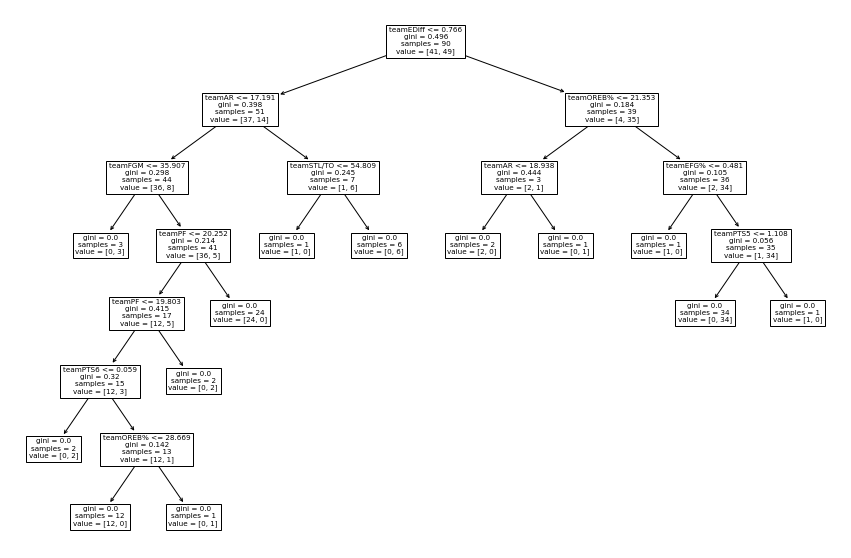

In [31]:
decisiontree.fit(train_x, train_y)
plt.figure(figsize=(15,10))
plot_tree(decisiontree, feature_names = train_x.columns);

#### 4. Do cross-validation on Random Forests

In [12]:
depths = [5, 10, 15, 20]
num_trees = [5, 10, 100, 1000]
randomforest_scores = []
for depth in depths:
    for n in num_trees:
        randomforest = RandomForestClassifier(max_depth = depth, n_estimators=n)
        randomforest_scores.append(np.mean(cross_val_score(randomforest, train_x, train_y, cv=5)))
print('The best cross validation score for random forest is: ', max(randomforest_scores))

The best cross validation score for random forest is:  0.7555555555555555


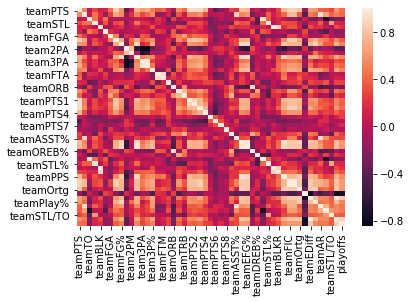

In [13]:
sns.heatmap(train_x.corr())

#### 5. Using PCA + logistic regression

In [14]:
pca = PCA(5)
logistic = LogisticRegression(max_iter=10000, tol=0.5)
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

pca_lr_score = np.mean(cross_val_score(pipe, train_x, train_y))
print('PCA + logistic regression cross validation accuracy: ', pca_lr_score)

PCA + logistic regression cross validation accuracy:  0.7666666666666667


### TODOS:
- visualisations eg. EDA, heatmap correlation of features, fine-tuning accuracy for random forest, visualisation for pca clusters, simple histograms, should do some sort of time series test
- can look at how fivethirtyeight defines a 'good' basketball team. Test it to see if it actually holds true in this dataset 
- potential features to add: draft pick #, budget
- predict how good in NBA based on NCAA stats (should try to find a good stat)
- compare the pros/cons for the different classification models based on the same dataset
- seeing if better than baseline (predicting next yr from this year if they're in playoffs)
- fine_tune hyperparameters for PCA + logistic regression model

- Code organisation:
    - should make the cleaning all in one function 

other ideas:
- see what type of shots/position is most popular over time
- salary efficiency 

### A list of observations to include in the report:
- originally, when using all the given stats, the features were quite correlated